In [62]:
import matplotlib.pyplot as plt

from SACalcs import get_johansen, hurst, half_life

import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller

def run_lr(s1, s2, interval='15m', period='60d'):
    sprd = yf.download([s1, s2], interval=interval, period=period) #INTRADAY requires 60d or less!
    sprd = sprd['Adj Close'].dropna()
    diff = sprd[s2] - 3 * sprd[s1]
    # diff.plot(figsize=(20,10))

    r = linregress(sprd[s1], sprd[s2])
    hr = r.slope
    hr
    # print(f'HR: {hr}')

    series = sprd[s2] - hr * sprd[s1]
    # series.plot(figsize=(20,10))
    return series


series = run_lr('GOOG','GOOGL')
print(f'THIS is cheating a bit -- bc we dont have all the data we need to GET hedge on one set, and TEST on another...')

[*********************100%***********************]  2 of 2 completed
THIS is cheating a bit -- bc we dont have all the data we need to GET hedge on one set, and TEST on another...


In [63]:
%%timeit

run_lr('GOOG','GOOGL') #240ms from this

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached.
287 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [167]:
def get_calmar(pnl_arr):
    # accepts the TRADE totals in spread, but really turning into pcts would only scale it, likely not impact Calmar

    eq_arr = np.cumsum(pnl_arr)
    peak, mdd = 0,0
    for eq in eq_arr:
        peak = max(eq, peak)
        dd = peak - eq
        mdd = max(dd, mdd)

    if mdd == 0:
        return np.inf
    return eq_arr[-1] / mdd


[*********************100%***********************]  2 of 2 completed
2022-07-26 11:45:00-04:00 0.029130679187379372
Total Profit (in SPREAD chg, Best Ex assumed (no slpg) :  7.419163076841443
[*********************100%***********************]  1 of 1 completed
Rough approximation of $ PNL (60d period):  7322.713956842504
Avg Transaction (in Spread) 0.037470520590108296
Avg Win Trans   (in Spread) 0.05853229477880291
Avg Trade Duration (in Bars) 5.136363636363637


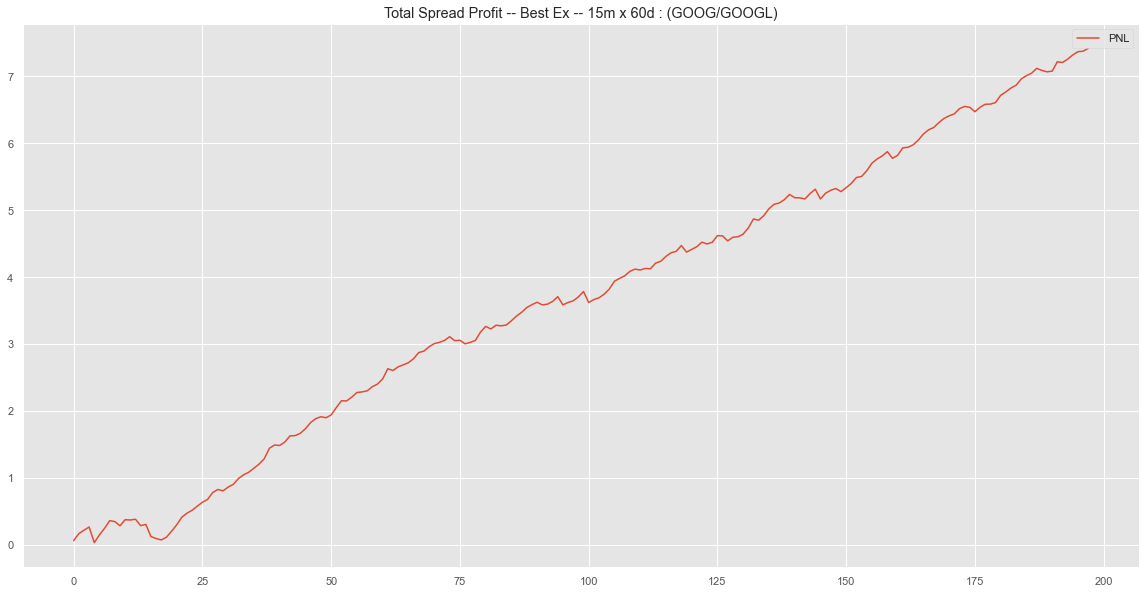

In [180]:
def quick_backtest(s1,s2, stds=1, interval='15m', period='60d'):

    profit_in_spread = 0
    trades = []

    series = run_lr(s1,s2,interval, period)
    df = pd.DataFrame(series, columns=['Series'])

    df['mid'] = df.Series.rolling(10).mean()
    df['upper'] = df.mid + df.Series.rolling(10).std() * stds
    df['lower'] = df.mid - df.Series.rolling(10).std() * stds
    df.dropna(inplace=True)

    pos = 0

    longs, shorts = [], [] #THESE are lists of pairs

    trade = [] #Will hold [dir, enter, exit)

    long, short = [],[] #These are pairs
    beg, end, trade_lengths = 0,0,[]
    i = 0
    for dt, row in df.iterrows():
        if i == 0: print(dt, row.mid)

        if pos == 0:
            if row.Series > row.upper:
                trade = [-1, row.Series]
                short.append(row.Series)
                pos = -1
                beg = i


            if row.Series < row.lower:
                trade = [1, row.Series]
                long.append(row.Series)
                pos = 1
                beg = i

        if pos > 0:
            if row.Series >= row.mid:
                trade.append(row.Series)
                trades.append(trade)


                long.append(row.Series)
                longs.append(long)
                # trades.append(long) #JUST check if this pair is IN
                pos = 0
                trade_lengths.append(i - beg)

        if pos < 0:
            if row.Series <= row.mid:
                trade.append(row.Series)
                trades.append(trade)
                pos = 0
                trade_lengths.append(i - beg)

        i += 1

    # print(trades)

    # triples format is [int: [-1,1], entry series price, exit series price] --> for LONGS, we want END - BEGIN, for SHORTS, we want BEGIN - END, given it's short.
    totals = [i[2] - i[1] if i[0] == 1 else i[1] - i[2] for i in trades]
    # print(totals)

    total_sprd_pnl = sum(totals)
    print('Total Profit (in SPREAD chg, Best Ex assumed (no slpg) : ', total_sprd_pnl)

    tots = pd.DataFrame(totals,columns=['PNL'])
    tots.cumsum().plot(figsize=(20,10), title=f'Total Spread Profit -- Best Ex -- {interval} x {period} : ({s1}/{s2})')
    # totals.set_index(df.index)

    pos_size = 100000
    tmp = yf.download(s1)
    p = tmp['Adj Close'].iloc[-1]
    shares = int(pos_size / p)
    dlr_pnl = shares * total_sprd_pnl
    print(f'Rough approximation of $ PNL ({period} period): ', dlr_pnl)

    print(f'Avg Transaction (in Spread) {np.mean(totals)}')
    print(f'Avg Win Trans   (in Spread) {np.mean([i for i in totals if i > 0])}')
    print(f'Avg Trade Duration (in Bars) {np.mean(trade_lengths)}')
    return totals

tot = quick_backtest('GOOG','GOOGL')

[*********************100%***********************]  2 of 2 completed
2022-10-12 09:39:00-04:00 -1.2921124627653129
Total Profit (in SPREAD chg, Best Ex assumed (no slpg) :  2.3221122083902515
[*********************100%***********************]  1 of 1 completed
Rough approximation of $ PNL (5d period):  2289.602637472788
Avg Transaction (in Spread) 0.06450311689972921
Avg Win Trans   (in Spread) 0.07618459252910226
Avg Trade Duration (in Bars) 3.6666666666666665
DSR 1.078475907813659
Calmar: 40.28973404490904
Ann SR: 324.83436539318535


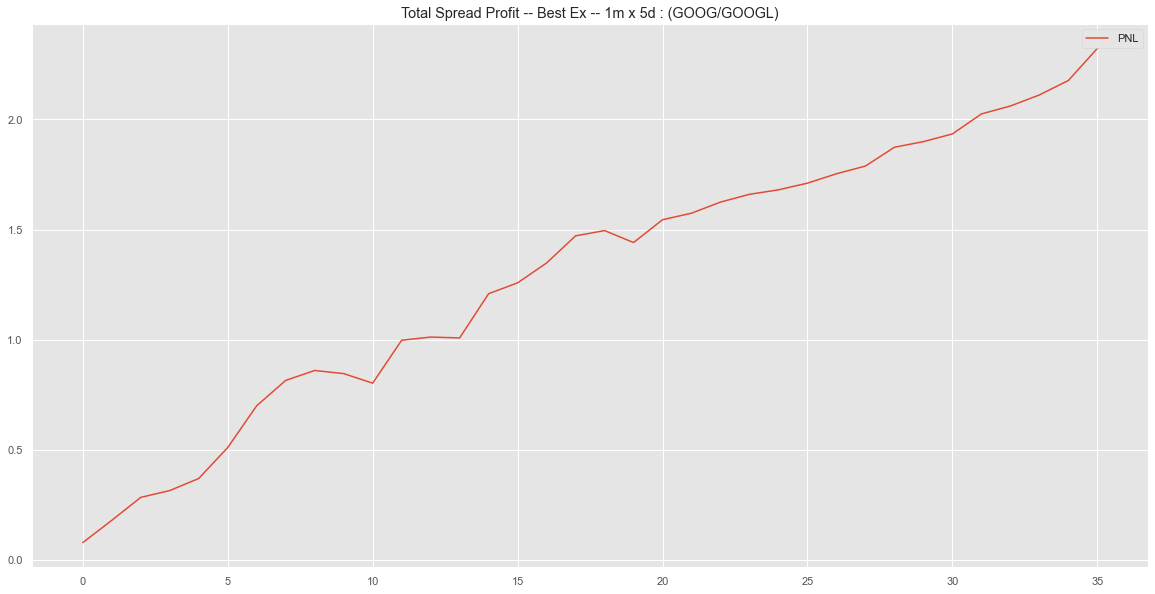

In [181]:
tot = quick_backtest('GOOG','GOOGL',stds=2.25, interval='1m', period='5d') #WOW -- CAN crank up the bounds.
DSR = np.mean(tot) / np.std(tot)
print(f'DSR {DSR}')
print(f'Calmar: {get_calmar(tot)}')
print(f'Ann SR: {DSR * np.sqrt(252 * 60 * 6)}')

[*********************100%***********************]  2 of 2 completed
2022-07-27 11:30:00-04:00 0.08265157430769107
Total Profit (in SPREAD chg, Best Ex assumed (no slpg) :  3.388575107471084
[*********************100%***********************]  1 of 1 completed
Rough approximation of $ PNL (60d period):  3341.135055966489
Avg Transaction (in Spread) 0.06644264916609968
Avg Win Trans   (in Spread) 0.09493693290061742
Avg Trade Duration (in Bars) 5.176470588235294
DSR 0.6686530190740467
Calmar: 13.254673566250933
Ann SR: 201.39669096500938


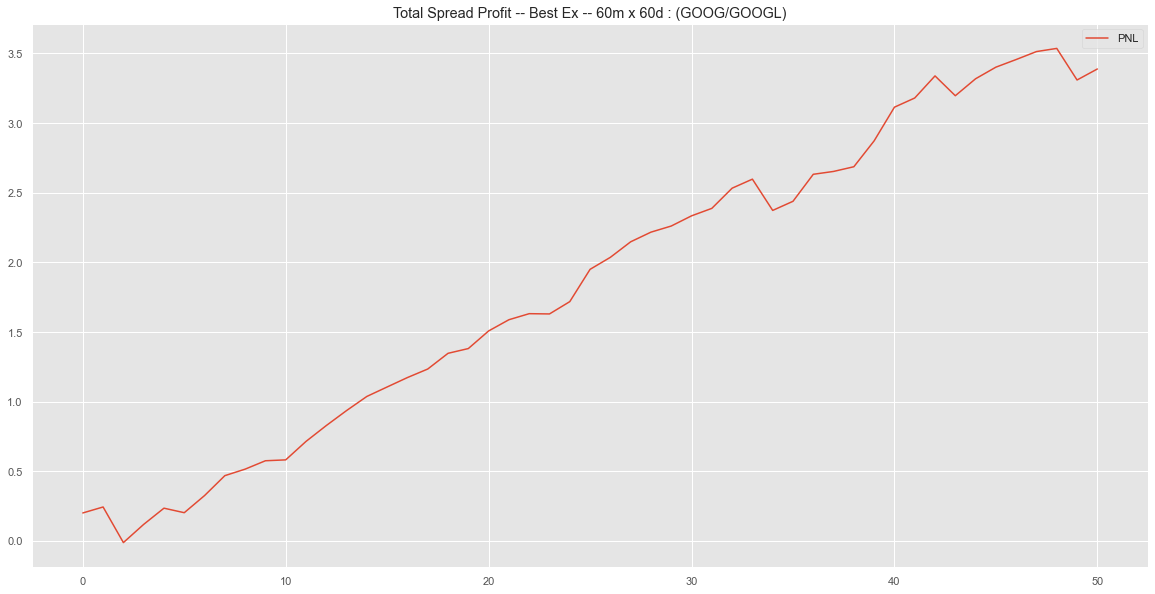

In [183]:
tot = quick_backtest('GOOG','GOOGL',stds=1, interval='60m', period='60d') #Still fucking good...
DSR = np.mean(tot) / np.std(tot)
print(f'DSR {DSR}')
print(f'Calmar: {get_calmar(tot)}')
print(f'Ann SR: {DSR * np.sqrt(252 * 60 * 6)}')

[*********************100%***********************]  2 of 2 completed
2017-11-01 00:00:00 1.6987673238746432
Total Profit (in SPREAD chg, Best Ex assumed (no slpg) :  29.645322589729552
[*********************100%***********************]  1 of 1 completed
Rough approximation of $ PNL (5y period):  29230.288073473337
Avg Transaction (in Spread) 0.16199629830453308
Avg Win Trans   (in Spread) 0.2109725020991548
Avg Trade Duration (in Bars) 4.398907103825136
DSR 0.4344055687550255
Calmar: 15.216312285431224


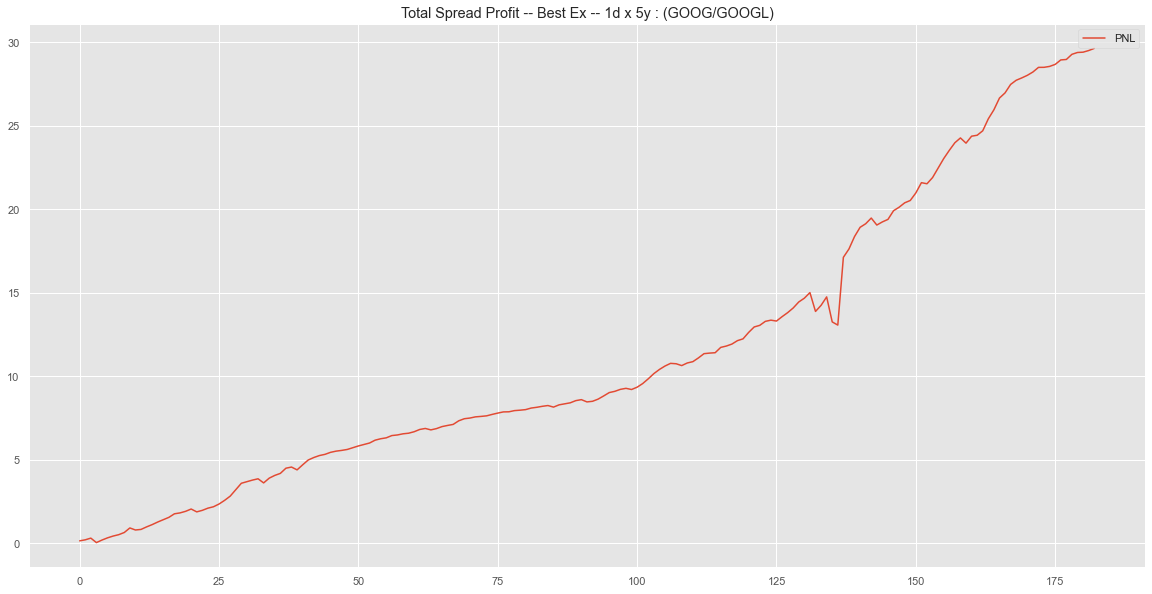

In [184]:
tot = quick_backtest('GOOG','GOOGL',stds=1, interval='1d', period='5y') #WOW
DSR = np.mean(tot) / np.std(tot)
print(f'DSR {DSR}')
print(f'Calmar: {get_calmar(tot)}')

In [70]:


def quick_backtest_no_logs(s1,s2, stds=1, interval='15m', period='60d', dlr=False):


    trades = []

    series = run_lr(s1,s2,interval, period)
    df = pd.DataFrame(series, columns=['Series'])

    df['mid'] = df.Series.rolling(10).mean()
    # sig = df.Series.rolling(10).std()
    df['upper'] = df.mid + df.Series.rolling(10).std() * stds
    df['lower'] = df.mid - df.Series.rolling(10).std() * stds
    df.dropna(inplace=True)

    pos = 0
    trade = [] #Will hold [dir, enter, exit)
    i = 0
    for dt, row in df.iterrows():
        # if i == 0: print(dt, row.mid)

        if pos == 0:
            if row.Series > row.upper:
                trade = [-1, row.Series]
                # short.append(row.Series)
                pos = -1

            if row.Series < row.lower:
                trade = [1, row.Series]
                # long.append(row.Series)
                pos = 1

        if pos > 0:
            if row.Series >= row.mid:
                trade.append(row.Series)
                trades.append(trade)


                # long.append(row.Series)
                # longs.append(long)
                # trades.append(long) #JUST check if this pair is IN
                pos = 0

        if pos < 0:
            if row.Series <= row.mid:
                trade.append(row.Series)
                trades.append(trade)
                pos = 0

        i += 1

    # print(trades)

    # triples format is [int: [-1,1], entry series price, exit series price] --> for LONGS, we want END - BEGIN, for SHORTS, we want BEGIN - END, given it's short.
    totals = [i[2] - i[1] if i[0] == 1 else i[1] - i[2] for i in trades]
    # print(totals)

    total_sprd_pnl = sum(totals)


    # tots = pd.DataFrame(totals,columns=['PNL'])
    # tots.cumsum().plot(figsize=(20,10))

    if dlr:
        pos_size = 100000
        tmp = yf.download(s1)
        p = tmp['Adj Close'].iloc[-1]
        shares = int(pos_size / p)
        dlr_pnl = shares * total_sprd_pnl
    else:
        dlr_pnl = None

    # print('Total Profit (in SPREAD chg, Best Ex assumed (no slpg) : ', total_sprd_pnl)
    # print(f'Rough approximation of $ PNL ({period} period): ', dlr_pnl)
    return total_sprd_pnl, dlr_pnl, totals

total_sprd, _, totals = quick_backtest_no_logs('GOOG','GOOGL', stds=1)
print(f'Total pnl, Avg per trade, N Trades')
total_sprd, np.mean(totals), len(totals)#AVG trade profit -- 4.29 ticks...

[*********************100%***********************]  2 of 2 completed
Total pnl, Avg per trade, N Trades


(8.388540619249014, 0.04215347044848751, 199)

In [72]:
%%timeit

quick_backtest_no_logs('GOOG','GOOGL')

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
323 ms ± 94.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[*********************100%***********************]  2 of 2 completed
2022-10-07 09:40:00-04:00 -2.3123359374592503
Total Profit (in SPREAD chg, Best Ex assumed (no slpg) :  2.837711812220519
[*********************100%***********************]  1 of 1 completed
Rough approximation of $ PNL (5d period):  14202.747620163696
Avg Transaction (in Spread) 0.013137554686206107
Avg Trade Duration (in Bars) 4.944444444444445
[*********************100%***********************]  2 of 2 completed
Time in MS: 326.4234


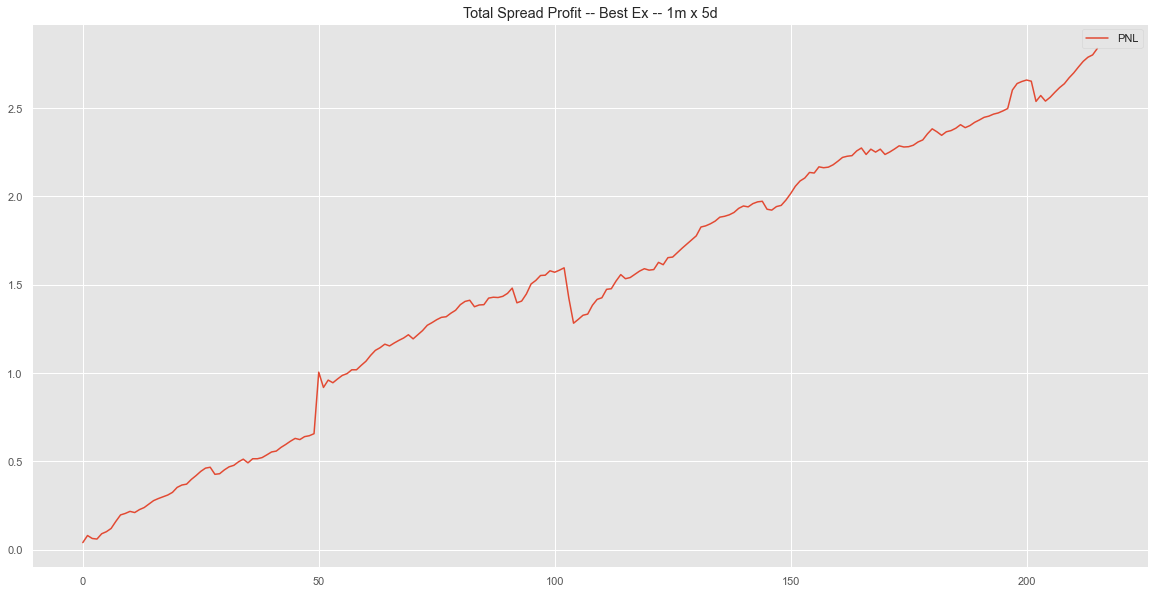

In [153]:
import time


_ = quick_backtest('EWA','EWC', interval='1m', period='5d')

t1 = time.time_ns()
quick_backtest_no_logs('EWA','EWC')
t2 = time.time_ns()
print(f'Time in MS: {(t2 - t1) / 1000 / 1000}')

MSE 0.011615502626551154, MAE 0.08479805926728348


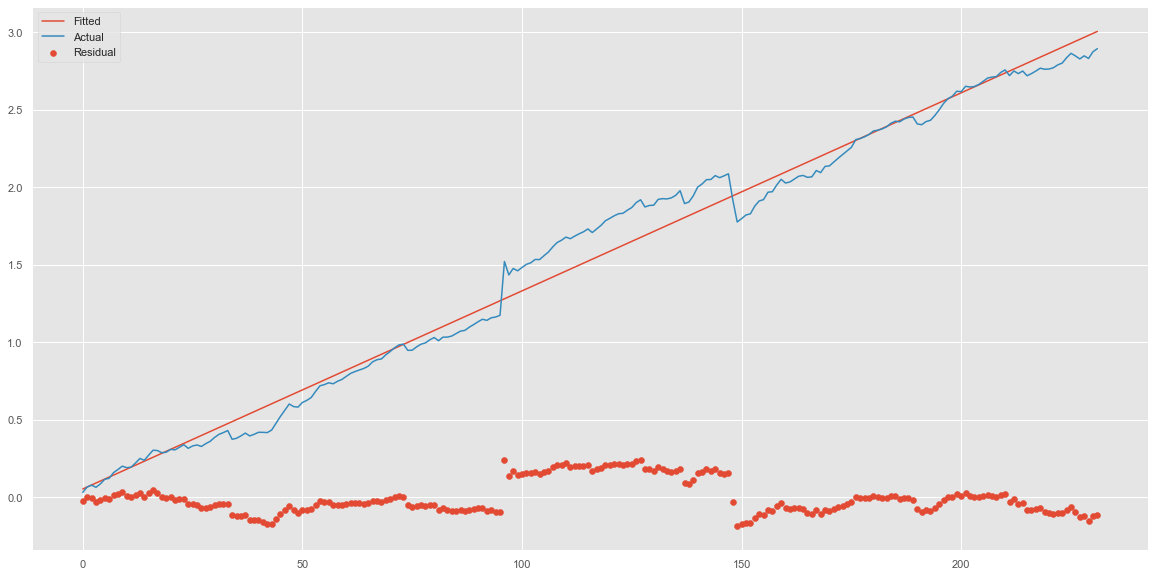

In [152]:
pnls = _
eq = np.cumsum(pnls)
y,x = eq, list(range(len(eq)))

m, b = np.polyfit(x, y, 1)

fitted = np.array(m)*np.array(x) + np.array(b)
fitted

import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2)
#
# axs[0].plot(x, fitted )
# axs[1].plot(x, y)
# import seaborn as sns
# sns.set_theme()
plt.style.use('ggplot')

plt.figure(figsize=(20,10))
plt.plot(x, fitted, label='Fitted')
plt.plot(x, y, label='Actual')
plt.scatter(x, y - fitted, label='Residual')
# plt.plot(x, np.abs(np.cumsum(y - fitted)), label='Cumulative Residual') #Not very helpful... weird?
plt.legend()

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse, mae = mean_squared_error(y, fitted), mean_absolute_error(y, fitted)
print(f'MSE {mse}, MAE {mae}')

In [156]:
print('At given speed -- it would take about 5 minutes per 1000 tests (assuming io still required, no parallel).')
print(f'200 test per minute')

At given speed -- it would take about 5 minutes per 1000 tests (assuming io still required, no parallel).
200 test per minute


[*********************100%***********************]  2 of 2 completed
2022-10-12 09:39:00-04:00 -0.637308900655006
Total Profit (in SPREAD chg, Best Ex assumed (no slpg) :  15.807811096286457
[*********************100%***********************]  1 of 1 completed
Rough approximation of $ PNL (5d period):  4252.301184901057
Avg Transaction (in Spread) 0.19277818410105435
Avg Win Trans   (in Spread) 0.19277818410105435
Avg Trade Duration (in Bars) 1.5853658536585367
DSR 1.9097177435364923
Calmar: inf
Ann SR: 575.202419272741
FUCK there are ALOT of viable relationships...


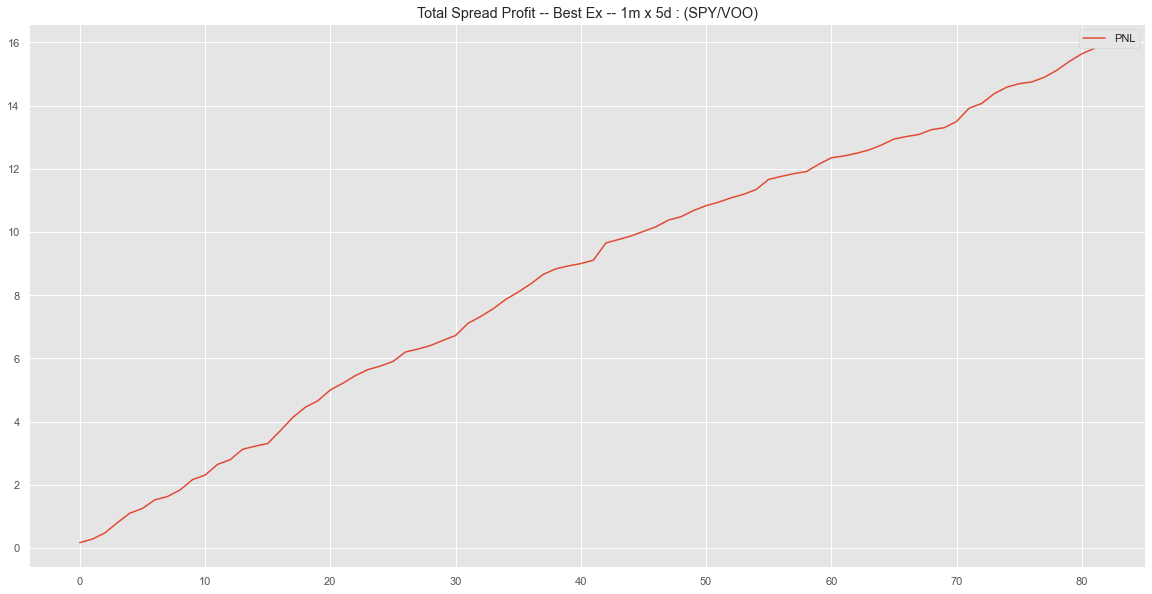

In [185]:
tot = quick_backtest('SPY','VOO',stds=2, interval='1m', period='5d') #WOW -- CAN crank up the bounds. REALLY alot of stuff in the
DSR = np.mean(tot) / np.std(tot)
print(f'DSR {DSR}')
print(f'Calmar: {get_calmar(tot)}')
print(f'Ann SR: {DSR * np.sqrt(252 * 60 * 6)}')

print('FUCK there are ALOT of viable relationships...')

In [178]:
print(f' ---- Execution SAFETY / Forgiveness (as a metric for universe) -----')
print(f'EF (Execution Forgiveness)\n')

print(f'Maybe we create a Margin For Error calc (i.e. avg taking cost vs avg edge in interval).')
print(f'Example:')
print(f'\tSPY x VOO -> ~1 - 2 ticks per side.')
print(f'\tSPY x VOO -> 15 ticks in avg transaction (via spread).')
print(f'\tSPY x VOO -> ~11 - 13 ticks of safety. \n\t\t(1.5 - 2 ticks per side, 3 - 4 per rt, split between 2 smaller orders bc of spread; 15.5 - 3 -> 12.5; 15.5 - 4 -> 11.5) ')

 ---- Execution SAFETY / Forgiveness (as a metric for universe) -----
EF (Execution Forgiveness)

Maybe we create a Margin For Error calc (i.e. avg taking cost vs avg edge in interval).
Example:
	SPY x VOO -> ~1 - 2 ticks per side.
	SPY x VOO -> 15 ticks in avg transaction (via spread).
	SPY x VOO -> ~11 - 13 ticks of safety. 
		(1.5 - 2 ticks per side, 3 - 4 per rt, split between 2 smaller orders bc of spread; 15.5 - 3 -> 12.5; 15.5 - 4 -> 11.5) 
